In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install dagshub --upgrade
!pip install -q pandas scikit-learn mlflow joblib kaggle
!pip install numpy==1.24.4
!pip install pmdarima

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.25.1 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.

  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0

In [1]:
!pip install numpy==1.26.4

!pip install --no-binary :all: pmdarima

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
import zipfile
import mlflow
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("walmart_sales_forecasting_updated")

2025/08/02 08:39:28 INFO mlflow.tracking.fluent: Experiment with name 'walmart_sales_forecasting_updated' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/735797568602408188', creation_time=1754123968794, experiment_id='735797568602408188', last_update_time=1754123968794, lifecycle_stage='active', name='walmart_sales_forecasting_updated', tags={}>

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!mkdir -p data
!unzip walmart-recruiting-store-sales-forecasting.zip -d data/

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 1.10GB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: data/features.csv.zip   
  inflating: data/sampleSubmission.csv.zip  
  inflating: data/stores.csv         
  inflating: data/test.csv.zip       
  inflating: data/train.csv.zip      


In [7]:
data_dir = "data"
for file in os.listdir(data_dir):
    if file.endswith(".zip"):
        file_path = os.path.join(data_dir, file)
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"Unzipped {file}")

!rm data/*.zip
print("Data files:", os.listdir("data"))

Unzipped features.csv.zip
Unzipped train.csv.zip
Unzipped test.csv.zip
Unzipped sampleSubmission.csv.zip
Data files: ['stores.csv', 'test.csv', 'sampleSubmission.csv', 'features.csv', 'train.csv']


In [8]:
import os
print(os.listdir("data"))

['stores.csv', 'test.csv', 'sampleSubmission.csv', 'features.csv', 'train.csv']


In [9]:
train = pd.read_csv("data/train.csv")
stores = pd.read_csv("data/stores.csv")
features = pd.read_csv("data/features.csv")
test = pd.read_csv("data/test.csv")

print("Train shape:", train.shape)
print("Stores shape:", stores.shape)
print("Features shape:", features.shape)
print("Test shape:", test.shape)

Train shape: (421570, 5)
Stores shape: (45, 3)
Features shape: (8190, 12)
Test shape: (115064, 4)


In [10]:
def preprocess_data(train, test, stores, features):
    #Converting dates
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    features['Date'] = pd.to_datetime(features['Date'])

    #Merging datasets
    train_full = train.merge(stores, on='Store').merge(features, on=['Store', 'Date'])
    test_full = test.merge(stores, on='Store').merge(features, on=['Store', 'Date'])

    print(f"Merged train shape: {train_full.shape}")
    print(f"Merged test shape: {test_full.shape}")

    #fixing duplicate IsHoliday_y IsHoliday_x columns
    if 'IsHoliday_x' in train_full.columns and 'IsHoliday_y' in train_full.columns:
        train_full['IsHoliday'] = train_full['IsHoliday_x']
        train_full = train_full.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

    if 'IsHoliday_x' in test_full.columns and 'IsHoliday_y' in test_full.columns:
        test_full['IsHoliday'] = test_full['IsHoliday_x']
        test_full = test_full.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

    #filling missing values
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    train_full[markdown_cols] = train_full[markdown_cols].fillna(0)
    test_full[markdown_cols] = test_full[markdown_cols].fillna(0)

    train_full['CPI'] = train_full['CPI'].fillna(train_full['CPI'].median())
    train_full['Unemployment'] = train_full['Unemployment'].fillna(train_full['Unemployment'].median())
    train_full['IsHoliday'] = train_full['IsHoliday'].astype(int)

    test_full['CPI'] = test_full['CPI'].fillna(test_full['CPI'].median())
    test_full['Unemployment'] = test_full['Unemployment'].fillna(test_full['Unemployment'].median())
    test_full['IsHoliday'] = test_full['IsHoliday'].astype(int)

    #data cleaning
    if 'Weekly_Sales' in train_full.columns:
        print(f"Original train data: {len(train_full)} rows")
        train_full = train_full[train_full['Weekly_Sales'] >= 0]
        print(f"After removing negative sales: {len(train_full)} rows")

        Q1 = train_full['Weekly_Sales'].quantile(0.25)
        Q3 = train_full['Weekly_Sales'].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 2.5 * IQR

        holiday_mask = (train_full['IsHoliday'] == 1) | (train_full['Date'].dt.month.isin([11, 12]))
        outlier_mask = train_full['Weekly_Sales'] > upper_bound
        outliers_to_cap = (~holiday_mask & outlier_mask).sum()

        print(f"Outliers to cap: {outliers_to_cap}")
        train_full.loc[~holiday_mask & outlier_mask, 'Weekly_Sales'] = upper_bound

    train_full = train_full.sort_values(['Store', 'Dept', 'Date'])
    test_full = test_full.sort_values(['Store', 'Dept', 'Date'])

    return train_full, test_full


In [11]:
def add_features(df):
    df = df.copy()

    #converting temperature
    df['Temperature'] = (df['Temperature'] - 32) * (5.0 / 9.0)

    #time features
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter

    #holiday features
    df['SuperbowlWeek'] = df['WeekOfYear'].isin([6]).astype(int)
    df['LaborDayWeek'] = df['WeekOfYear'].isin([36]).astype(int)
    df['ThanksgivingWeek'] = df['WeekOfYear'].isin([47, 48]).astype(int)
    df['ChristmasWeek'] = df['WeekOfYear'].isin([52, 1]).astype(int)

    df['Days_to_Thanksgiving'] = (pd.to_datetime(df['Year'].astype(str) + '-11-24') - df['Date']).dt.days
    df['Days_to_Christmas'] = (pd.to_datetime(df['Year'].astype(str) + '-12-24') - df['Date']).dt.days

    df.loc[df['Days_to_Christmas'] < -30, 'Days_to_Christmas'] += 365

    type_mapping = {'A': 3, 'B': 2, 'C': 1}
    df['Type'] = df['Type'].map(type_mapping)

    return df

In [12]:
train_full, test_full = preprocess_data(train, test, stores, features)
train_full = add_features(train_full)
test_full = add_features(test_full)

Merged train shape: (421570, 17)
Merged test shape: (115064, 16)
Original train data: 421570 rows
After removing negative sales: 420285 rows
Outliers to cap: 14153


In [13]:
def prepare_store_data(train_full, test_full):
    train_aggregated = {}
    test_aggregated = {}

    #features to use
    group_features = ['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                      'Type', 'Size', 'Day', 'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'Quarter',
                      'SuperbowlWeek', 'LaborDayWeek', 'ThanksgivingWeek', 'ChristmasWeek',
                      'Days_to_Thanksgiving', 'Days_to_Christmas'] + \
                     ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    #prcessing trainng data
    for store_id in tqdm(train_full['Store'].unique(), desc="Processing training stores"):
        store_data = train_full[train_full['Store'] == store_id].copy()

        weekly = store_data.groupby('Date').agg({
            **{col: 'first' for col in group_features},
            'Weekly_Sales': 'sum'
        }).reset_index()

        weekly = weekly.sort_values('Date').reset_index(drop=True)

        dept_props = store_data.groupby('Dept')['Weekly_Sales'].sum()
        total_sales = dept_props.sum()
        if total_sales > 0:
            dept_props = (dept_props / total_sales).to_dict()
        else:
            unique_depts = store_data['Dept'].unique()
            dept_props = {dept: 1/len(unique_depts) for dept in unique_depts}

        train_aggregated[store_id] = (weekly, dept_props)

    for store_id in tqdm(test_full['Store'].unique(), desc="Processing test stores"):
        store_data = test_full[test_full['Store'] == store_id].copy()
        weekly = store_data.groupby('Date').agg({col: 'first' for col in group_features}).reset_index()
        weekly = weekly.sort_values('Date').reset_index(drop=True)
        test_aggregated[store_id] = (weekly, None)

    return train_aggregated, test_aggregated, group_features

In [14]:
train_aggregated, test_aggregated, group_features = prepare_store_data(train_full, test_full)

Processing test stores: 100%|██████████| 45/45 [00:00<00:00, 77.40it/s]


In [15]:
def find_best_sarimax_params(series, seasonal_period=52, max_p=2, max_q=2):
    try:
        auto_model = auto_arima(
            series,
            seasonal=True,
            m=seasonal_period,
            max_p=max_p, max_q=max_q,
            max_P=1, max_Q=1,
            suppress_warnings=True,
            stepwise=True,
            error_action='ignore'
        )
        return auto_model.order, auto_model.seasonal_order, auto_model.aic()
    except:
        return (1, 1, 1), (1, 1, 1, seasonal_period), float('inf')

In [18]:
def train_store_models(train_aggregated):
    store_models = {}

    with mlflow.start_run(run_name="SARIMAX_Store_Models_Training"):
        mlflow.log_param("total_stores", len(train_aggregated))
        mlflow.log_param("seasonal_period", 52)

        successful_models = 0
        for store_id in tqdm(list(train_aggregated.keys()), desc="Training store models"):
            try:
                df, dept_props = train_aggregated[store_id]

                if len(df) < 52:
                    print(f"Skipping store {store_id}: insufficient data ({len(df)} weeks)")
                    continue

                #best params
                order, seasonal_order, aic = find_best_sarimax_params(df['Weekly_Sales'].values)

                #fit model
                df['Weekly_Sales'] = pd.to_numeric(df['Weekly_Sales'], errors='coerce').fillna(0).astype(np.float64)
                exog = df[group_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
                model = SARIMAX(
                   endog=df['Weekly_Sales'].values,
                   exog=exog.values,
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False
                )

                fitted_model = model.fit(
                    disp=False,
                    maxiter=100,
                    method='lbfgs'
                )

                store_models[store_id] = (fitted_model, dept_props, order, seasonal_order)
                successful_models += 1

            except Exception as e:
                print(f"Failed to fit model for store {store_id}: {str(e)}")
                continue

        mlflow.log_metric("successful_models", successful_models)
        mlflow.log_metric("success_rate", successful_models / len(train_aggregated))

        print(f"Successfully trained {successful_models} out of {len(train_aggregated)} store models")

    return store_models

In [19]:
store_models = train_store_models(train_aggregated)

Training store models: 100%|██████████| 46/46 [51:08<00:00, 66.72s/it]

Failed to fit model for store Weekly_Sales: too many values to unpack (expected 2)
Successfully trained 45 out of 46 store models


In [20]:
max_train_date = train_full['Date'].max()

In [21]:
def get_forecast(sample, store_models, test_aggregated, train_full):
    store = sample['Store']
    dept = sample['Dept']
    pred_date = sample['Date']

    if store not in store_models:
        store_avg = train_full[train_full['Store'] == store]['Weekly_Sales'].mean()
        dept_avg = train_full[(train_full['Store'] == store) & (train_full['Dept'] == dept)]['Weekly_Sales'].mean()
        return dept_avg if not pd.isna(dept_avg) else (store_avg if not pd.isna(store_avg) else 0)

    fitted_model, dept_props, order, seasonal_order = store_models[store]
    test_df, _ = test_aggregated[store]

    test_df = test_df.sort_values('Date').reset_index(drop=True)

    weeks_ahead = (pred_date - max_train_date).days // 7

    if weeks_ahead <= 0:
        return 0

    try:
        matching_rows = test_df[test_df['Date'] == pred_date]
        if matching_rows.empty:
            return 0

        exog_row = matching_rows.iloc[0][group_features].values.reshape(1, -1)

        forecast = fitted_model.forecast(steps=1, exog=exog_row)[0]

        if dept in dept_props:
            return max(0, forecast * dept_props[dept])
        else:
            return max(0, forecast / max(len(dept_props), 1))

    except Exception as e:
        dept_avg = train_full[(train_full['Store'] == store) & (train_full['Dept'] == dept)]['Weekly_Sales'].mean()
        return dept_avg if not pd.isna(dept_avg) else 0

In [22]:
def process_batch(batch_indices, test_full, store_models, test_aggregated, train_full):
    batch_results = []
    for idx in batch_indices:
        sample = test_full.iloc[idx]
        prediction = get_forecast(sample, store_models, test_aggregated, train_full)
        batch_results.append({
            'Id': f"{sample['Store']}_{sample['Dept']}_{sample['Date'].strftime('%Y-%m-%d')}",
            'Weekly_Sales': max(0, prediction)
        })
    return batch_results

In [23]:
submission_data = []

batch_size = 1000
total_rows = len(test_full)

for start_idx in tqdm(range(0, total_rows, batch_size), desc="Processing prediction batches"):
    end_idx = min(start_idx + batch_size, total_rows)
    batch_indices = list(range(start_idx, end_idx))

    batch_results = process_batch(batch_indices, test_full, store_models, test_aggregated, train_full)
    submission_data.extend(batch_results)

Processing prediction batches: 100%|██████████| 116/116 [06:01<00:00,  3.12s/it]


In [24]:
submission_df = pd.DataFrame(submission_data)
submission_df = submission_df.sort_values('Id').reset_index(drop=True)

In [25]:
with mlflow.start_run(run_name="Final_Predictions"):
    mlflow.log_metric("total_predictions", len(submission_df))
    mlflow.log_metric("avg_prediction", submission_df['Weekly_Sales'].mean())
    mlflow.log_metric("median_prediction", submission_df['Weekly_Sales'].median())
    mlflow.log_metric("zero_predictions", (submission_df['Weekly_Sales'] == 0).sum())
    mlflow.log_metric("max_prediction", submission_df['Weekly_Sales'].max())
    mlflow.log_metric("min_prediction", submission_df['Weekly_Sales'].min())

In [26]:
submission_df.to_csv("data/walmart_sarimax_submission_polished.csv", index=False)
print(f"Saved {len(submission_df)} predictions to submission file.")

Saved 115064 predictions to submission file.


In [29]:
print(f"Total stores processed: {len(train_aggregated)}")
print(f"Successful models trained: {len(store_models)}")
print(f"Model success rate: {len(store_models)/len(train_aggregated)*100:.1f}%")

Total stores processed: 46
Successful models trained: 45
Model success rate: 97.8%


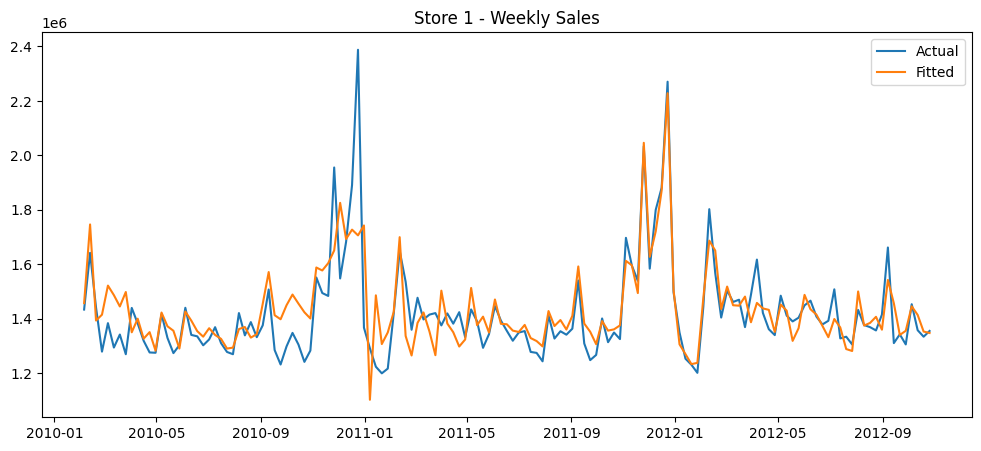

In [30]:
sample_store = 1
df, _ = train_aggregated[sample_store]
fitted, *_ = store_models[sample_store]

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Weekly_Sales'], label='Actual')
plt.plot(df['Date'], fitted.fittedvalues, label='Fitted')
plt.title(f'Store {sample_store} - Weekly Sales')
plt.legend()
plt.show()